Calls dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5157 entries, 0 to 5156
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   call_id  5157 non-null   int64
dtypes: int64(1)
memory usage: 40.4 KB
None

Customers dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       71810 non-null  int64  
 1   customer_name     71810 non-null  object 
 2   elite_level_code  46043 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB
None

Reasons dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66653 entries, 0 to 66652
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   call_id              66653 non-null  int64 
 1   primary_call_

<ipython-input-5-a6fa4747df6d>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['elite_level_code'].fillna(-1, inplace=True)  # -1 for non-elite customers


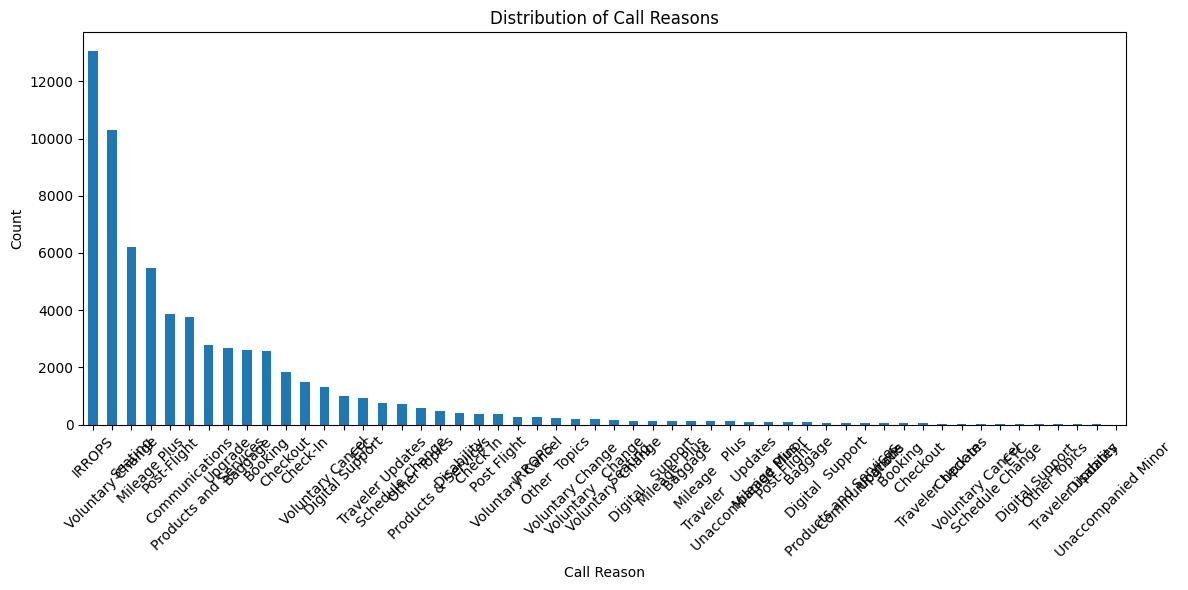

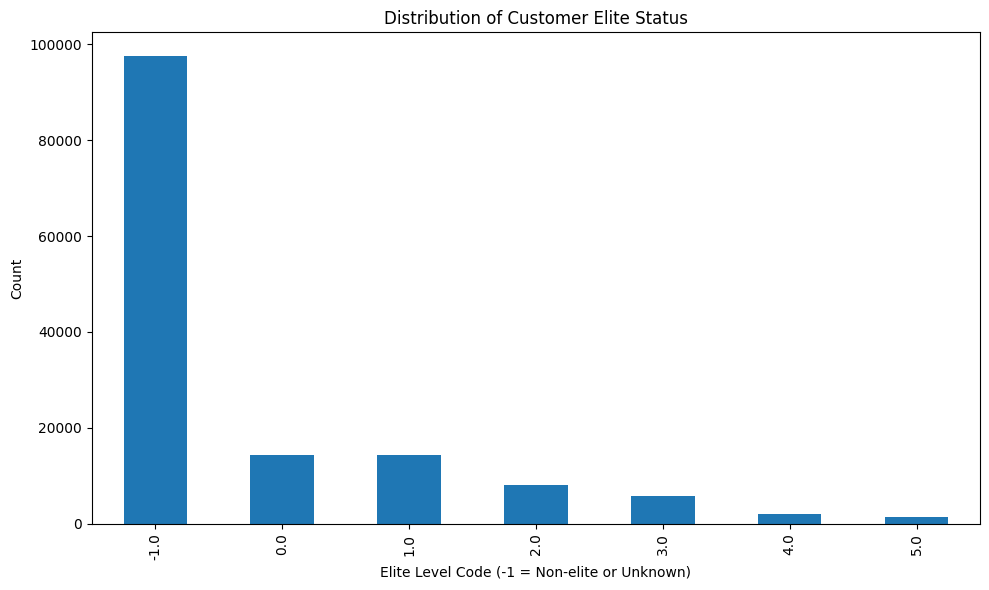

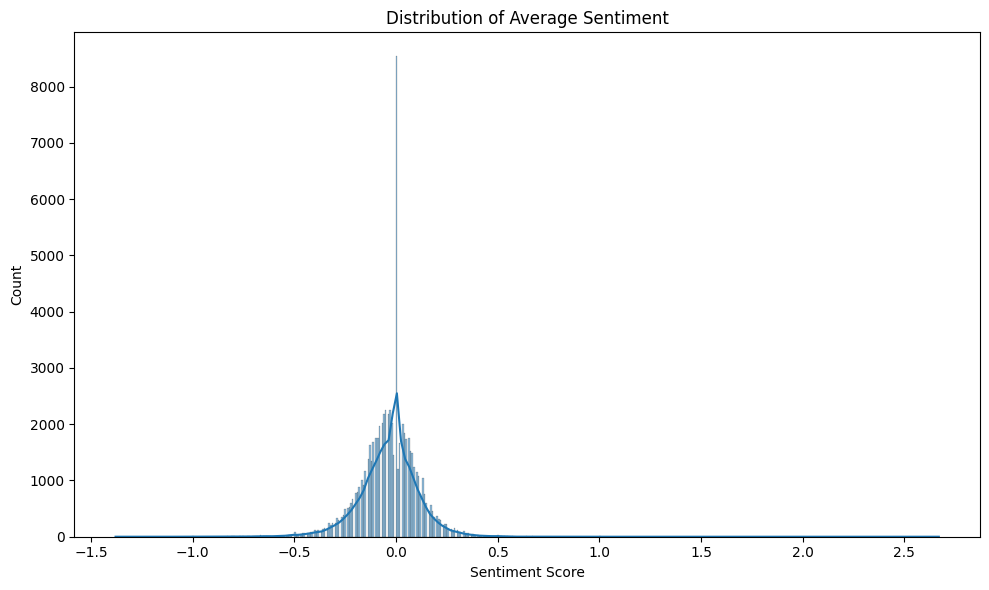

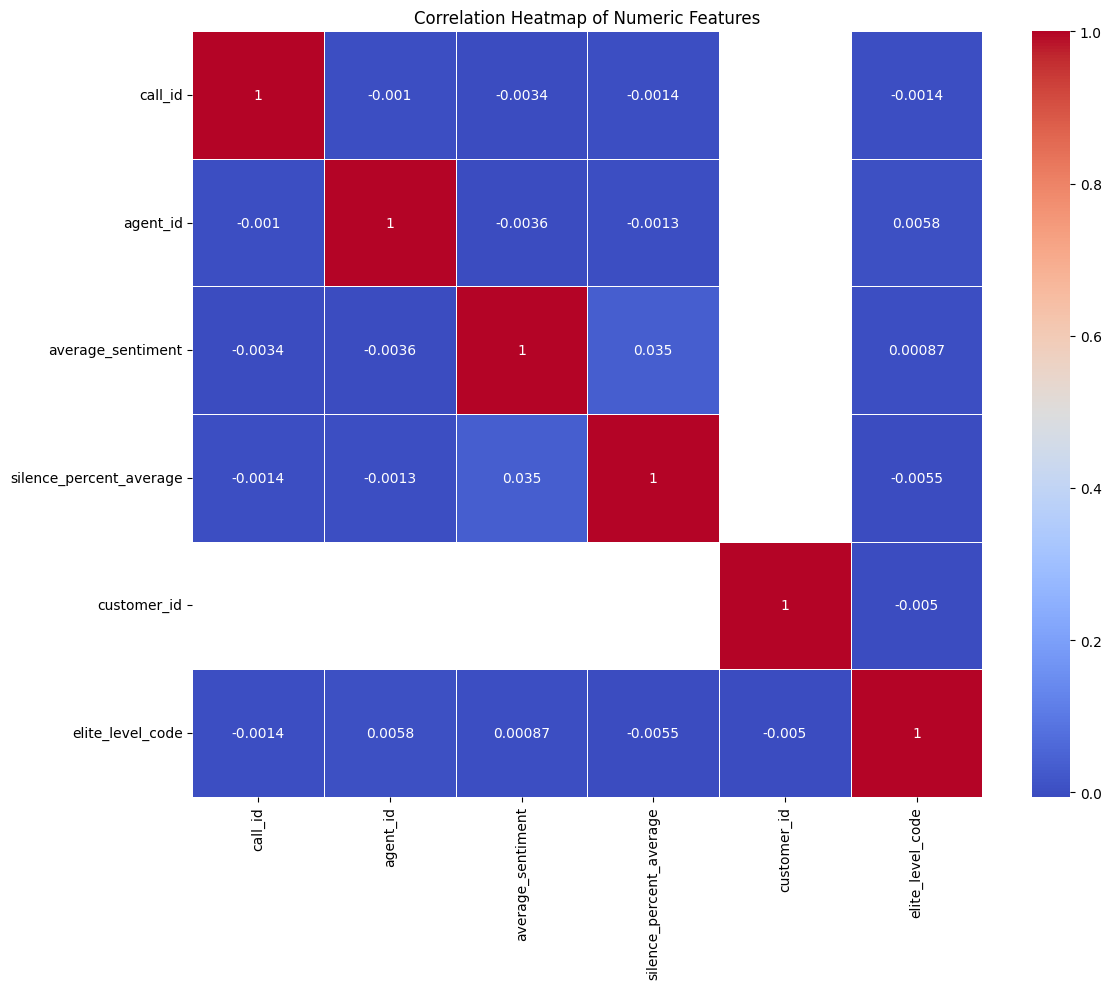

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Load the data
calls = pd.read_csv('/content/test.csv')
customers = pd.read_csv('/content/customers.csv')
reasons = pd.read_csv('/content/reason.csv')
sentiments = pd.read_csv('/content/sentiment_statistics.csv')

# Display info for each dataframe
print("Calls dataframe:")
print(calls.info())
print("\nCustomers dataframe:")
print(customers.info())
print("\nReasons dataframe:")
print(reasons.info())
print("\nSentiments dataframe:")
print(sentiments.info())

# Merge the dataframes
df = calls.merge(reasons, on='call_id', how='outer')
df = df.merge(sentiments, on='call_id', how='outer')
df = df.merge(customers, left_on='call_id', right_on='customer_id', how='outer')

print("\nMerged dataframe:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Data Preprocessing
df['elite_level_code'] = pd.to_numeric(df['elite_level_code'], errors='coerce')
df['elite_level_code'].fillna(-1, inplace=True)  # -1 for non-elite customers

# 1. Analyze available data

# Call reason distribution
if not df['primary_call_reason'].isnull().all():
    plt.figure(figsize=(12, 6))
    df['primary_call_reason'].value_counts().plot(kind='bar')
    plt.title('Distribution of Call Reasons')
    plt.xlabel('Call Reason')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data available for call reasons.")

# Customer elite status distribution
plt.figure(figsize=(10, 6))
df['elite_level_code'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Customer Elite Status')
plt.xlabel('Elite Level Code (-1 = Non-elite or Unknown)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Sentiment analysis (if data is available)
if not df['average_sentiment'].isnull().all():
    plt.figure(figsize=(10, 6))
    sns.histplot(df['average_sentiment'], kde=True)
    plt.title('Distribution of Average Sentiment')
    plt.xlabel('Sentiment Score')
    plt.tight_layout()
    plt.show()
else:
    print("No data available for sentiment analysis.")

# 2. Identify patterns in available data

# Correlation heatmap of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

In [3]:
!pip install pandas numpy scikit-learn fastapi uvicorn python-dotenv sqlalchemy psycopg2-binary nltk spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, mean_absolute_error
from sklearn.feature_extraction.text import HashingVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class CallCenterAnalyzer:
    def __init__(self):
        self.data = {}
        self.combined_data = None
        self.encoders = {}
        self.models = {}
        self.vectorizer = None

    def import_datasets(self):
        logger.info("Importing datasets...")
        file_names = ['calls', 'customers', 'reason', 'sentiment_statistics', 'test']
        for name in file_names:
            self.data[name] = pd.read_csv(f'{name}.csv')

    def integrate_data(self):
        logger.info("Integrating datasets...")
        self.combined_data = self.data['calls'].merge(self.data['customers'], on='customer_id', how='left')
        self.combined_data = self.combined_data.merge(self.data['reason'], on='call_id', how='left')
        self.combined_data = self.combined_data.merge(self.data['sentiment_statistics'], on='call_id', how='left')

    def clean_and_transform(self):
        logger.info("Cleaning and transforming data...")
        self.combined_data['call_duration'] = (pd.to_datetime(self.combined_data['call_end_datetime']) -
                                               pd.to_datetime(self.combined_data['call_start_datetime'])).dt.total_seconds() / 60
        self.combined_data['wait_time'] = (pd.to_datetime(self.combined_data['agent_assigned_datetime']) -
                                           pd.to_datetime(self.combined_data['call_start_datetime'])).dt.total_seconds() / 60

        self.combined_data['mp_status'] = self.combined_data['mp_status'].fillna(-1)
        self.encoders['mp_status'] = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        self.combined_data['mp_status_encoded'] = self.encoders['mp_status'].fit_transform(self.combined_data[['mp_status']])

        numerical_features = ['call_duration', 'wait_time', 'average_sentiment', 'silence_percent_average']
        scaler = RobustScaler()
        self.combined_data[numerical_features] = scaler.fit_transform(self.combined_data[numerical_features])

        self.vectorizer = HashingVectorizer(n_features=100)
        text_features = self.vectorizer.fit_transform(self.combined_data['call_transcript'].fillna(''))
        text_feature_names = [f'text_feature_{i}' for i in range(100)]
        text_features_df = pd.DataFrame(text_features.toarray(), columns=text_feature_names)
        self.combined_data = pd.concat([self.combined_data, text_features_df], axis=1)

    def train_models(self):
        logger.info("Training models...")
        features = ['call_duration', 'wait_time', 'average_sentiment', 'silence_percent_average',
                    'mp_status_encoded'] + [f'text_feature_{i}' for i in range(100)]

        X = self.combined_data[features]
        y_satisfaction = (self.combined_data['average_sentiment'] > 0).astype(int)
        y_duration = self.combined_data['call_duration']

        X_train, X_test, y_sat_train, y_sat_test, y_dur_train, y_dur_test = train_test_split(
            X, y_satisfaction, y_duration, test_size=0.2, random_state=42)

        self.models['satisfaction'] = ExtraTreesClassifier(n_estimators=100, random_state=42)
        self.models['satisfaction'].fit(X_train, y_sat_train)
        sat_pred = self.models['satisfaction'].predict(X_test)
        sat_f1 = f1_score(y_sat_test, sat_pred)
        logger.info(f"Satisfaction model F1 score: {sat_f1:.4f}")

        self.models['duration'] = HistGradientBoostingRegressor(random_state=42)
        self.models['duration'].fit(X_train, y_dur_train)
        dur_pred = self.models['duration'].predict(X_test)
        dur_mae = mean_absolute_error(y_dur_test, dur_pred)
        logger.info(f"Duration model MAE: {dur_mae:.4f}")

    def analyze_patterns(self):
        logger.info("Analyzing patterns...")
        plt.figure(figsize=(12, 8))
        sns.heatmap(self.combined_data[['call_duration', 'wait_time', 'average_sentiment', 'silence_percent_average']].corr(),
                    annot=True, cmap='coolwarm')
        plt.title("Correlation Heatmap of Key Metrics")
        plt.tight_layout()
        plt.savefig("metric_correlations.png")
        plt.close()

        plt.figure(figsize=(10, 6))
        sns.boxenplot(x='mp_status', y='call_duration', data=self.combined_data)
        plt.title("Call Duration by Customer Loyalty Status")
        plt.xlabel("Loyalty Status")
        plt.ylabel("Call Duration (minutes)")
        plt.tight_layout()
        plt.savefig("loyalty_duration_distribution.png")
        plt.close()

        reasons = self.combined_data['primary_call_reason'].value_counts()
        plt.figure(figsize=(12, 6))
        reasons.plot(kind='bar')
        plt.title("Distribution of Primary Call Reasons")
        plt.xlabel("Call Reason")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig("call_reason_distribution.png")
        plt.close()

    def generate_insights(self):
        logger.info("Generating insights...")
        avg_duration = self.combined_data['call_duration'].mean()
        avg_wait = self.combined_data['wait_time'].mean()
        logger.info(f"Average call duration: {avg_duration:.2f} minutes")
        logger.info(f"Average wait time: {avg_wait:.2f} minutes")

        top_reasons = self.combined_data['primary_call_reason'].value_counts().head(5)
        logger.info("Top 5 call reasons:")
        for reason, count in top_reasons.items():
            logger.info(f"  {reason}: {count}")

        sentiment_by_reason = self.combined_data.groupby('primary_call_reason')['average_sentiment'].mean().sort_values()
        logger.info("Average sentiment by call reason (top 5 negative):")
        for reason, sentiment in sentiment_by_reason.head().items():
            logger.info(f"  {reason}: {sentiment:.2f}")

    def predict_test_reasons(self):
        logger.info("Predicting reasons for test data...")
        test_data = self.data['test']
        test_features = self.vectorizer.transform(test_data['call_transcript'].fillna(''))
        test_features_df = pd.DataFrame(test_features.toarray(), columns=[f'text_feature_{i}' for i in range(100)])

        reason_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
        reason_model.fit(
            self.combined_data[[f'text_feature_{i}' for i in range(100)]],
            self.combined_data['primary_call_reason']
        )

        predicted_reasons = reason_model.predict(test_features_df)

        submission = pd.DataFrame({
            'call_id': test_data['call_id'],
            'primary_call_reason': predicted_reasons
        })
        submission.to_csv('test_predictions.csv', index=False)
        logger.info("Test predictions saved to 'test_predictions.csv'")

    def suggest_improvements(self):
        logger.info("Suggesting improvements...")
        suggestions = [
            "Implement an AI-powered chatbot to handle common queries and reduce call volume.",
            "Develop a predictive model to anticipate peak call times and adjust staffing accordingly.",
            "Create a comprehensive knowledge base for agents to quickly access information and reduce AHT.",
            "Implement speech analytics to identify common issues and improve first call resolution rates.",
            "Introduce a callback system for customers during high volume periods to manage wait times.",
            "Enhance the mobile app with self-service features to deflect calls for simple issues."
        ]
        for i, suggestion in enumerate(suggestions, 1):
            logger.info(f"{i}. {suggestion}")

def main():
    analyzer = CallCenterAnalyzer()
    analyzer.import_datasets()
    analyzer.integrate_data()
    analyzer.clean_and_transform()
    analyzer.train_models()
    analyzer.analyze_patterns()
    analyzer.generate_insights()
    analyzer.predict_test_reasons()
    analyzer.suggest_improvements()

if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'calls.csv'